In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import tensorflow_addons as tfa

%run ../gridsearch/xception.ipynb

In [4]:
# Load a denoised dataset
dataset = "../../data/data_v1d.npz"

with np.load(dataset) as data:
    print("Available variables:", data.files)
    image = data["img_denoised"]
    label = data["label"]

Available variables: ['img_denoised', 'label', 'psf_r']


In [5]:
# Use unscaled images. Let TF normalize the data.
X = image[..., np.newaxis]
input_shape = X.shape[1:]

# Scale the labels between -1 and 1 using the full dataset. We know the ranges of generated labels.
scaler = MinMaxScaler(feature_range=(-1, 1))
y = scaler.fit_transform(label)
output_shape = y.shape[1:]

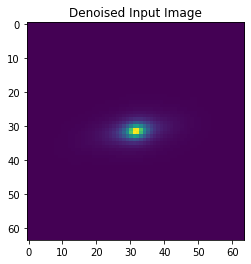

In [15]:
plt.imshow(X[0].reshape(64, 64))
plt.title("Denoised Input Image");

In [6]:
# Build a small Xception model. SeparableConv2D layers form Xception blocks.
model = build_xception_model(
    input_shape, output_shape, conv2d_num_filters=16, sep_num_filters=64, num_residual_blocks=8
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
normalization (Normalization)   (None, 64, 64, 1)    3           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   416         normalization[0][0]              
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 32, 32, 64)   1232        conv2d[0][0]                     
______________________________________________________________________________________________

Non-trainable params: 3
__________________________________________________________________________________________________


In [7]:
# Configure the model
model.compile(optimizer="adam", loss="mse")

# Setup callbacks. TQDM is used due to issues with the default progress bar on my TF2.1 installation.
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tqdm_callback = tfa.callbacks.TQDMProgressBar()
checkpoint = tf.keras.callbacks.ModelCheckpoint("edsr-xception.tf", save_best_only=True)

# Adapt the normalization layer to the data
adapt_model(model, X)
# Train the best model on the full dataset
history = model.fit(
    X,
    y,
    batch_size=32,
    epochs=100,
    validation_split=0.1,
    verbose=0,
    callbacks=[early_stopping, tqdm_callback, checkpoint],
)

Epoch 1/100



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: edsr-xception.tf/assets


INFO:tensorflow:Assets written to: edsr-xception.tf/assets


Epoch 2/100



INFO:tensorflow:Assets written to: edsr-xception.tf/assets


INFO:tensorflow:Assets written to: edsr-xception.tf/assets


Epoch 3/100



Epoch 4/100



Epoch 5/100



Epoch 6/100



INFO:tensorflow:Assets written to: edsr-xception.tf/assets


INFO:tensorflow:Assets written to: edsr-xception.tf/assets


Epoch 7/100



Epoch 8/100



Epoch 9/100



INFO:tensorflow:Assets written to: edsr-xception.tf/assets


INFO:tensorflow:Assets written to: edsr-xception.tf/assets


Epoch 10/100



Epoch 11/100



Epoch 12/100



Epoch 13/100



INFO:tensorflow:Assets written to: edsr-xception.tf/assets


INFO:tensorflow:Assets written to: edsr-xception.tf/assets


Epoch 14/100



Epoch 15/100



Epoch 16/100



Epoch 17/100



INFO:tensorflow:Assets written to: edsr-xception.tf/assets


INFO:tensorflow:Assets written to: edsr-xception.tf/assets


Epoch 18/100



Epoch 19/100



Epoch 20/100



Epoch 21/100



Epoch 22/100



Epoch 23/100



Epoch 24/100



Epoch 25/100



INFO:tensorflow:Assets written to: edsr-xception.tf/assets


INFO:tensorflow:Assets written to: edsr-xception.tf/assets


Epoch 26/100



Epoch 27/100



Epoch 28/100



Epoch 29/100



Epoch 30/100



Epoch 31/100



Epoch 32/100



Epoch 33/100



Epoch 34/100



Epoch 35/100


In [8]:
# Evaluate the model on the validation set
n_train = int(label.shape[0] * 0.9)
X_val = X[n_train:]
label_val = label[n_train:]

# Predict the labels and convert them to the original scale
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions)

# Compute RMSE for each label individually
np.set_printoptions(suppress=True)
rmse = np.sqrt(((label_val - predictions)**2).mean(axis=0))
rmse

array([5778.521     ,    0.7836832 ,    0.04665107,    0.07195907,
          0.0719365 ], dtype=float32)